# Sheet 4
- Ligia Priscila Coque Micán
- Sergio Amórtegui Ardila
- Juan Sotelo Aguilar

# Imports

In [1]:
import os
import copy
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as iter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
# Parallel processing
import joblib
from joblib import Parallel, delayed

## Exercise 1 (4 Points)

1. Write a function `show_rgb_instances(X, y)` that takes a set of $n$ instances and creates a $k \times 8$ plot grid where $k$ is the necessary number of rows to list all the instances of $X$ (when each row shows 8 instances). Assume that the RGB information in $X$ is distributed as follows: first 33% of the columns are the values for R channel, next 33% of the pixels for the G channel, and last 33% of the columns the pixels for the blue channel. Assuming that the pictures are quadratic, you can then automatically infer the width (and hence height) $w$ of the images. Then use `numpy.reshape` to derive a 4D tensor $(n \times w \times w \times 3)$ from $X$ (you might want to check `numpy.transpose` as well to orientate the axes properly). Then use `plt.imshow` to visualize those instances as images (check documentation to see how to plot rgb images).  

    Make sure that there are no axis labels (use `ax.set_xticklabels` etc.). 

    Use the labels in $y$ as titles for the images. 

    You should be able to clearly recognize the objects. If this is not the case, you have not transformed the data properly.

2. Download the dataset from rgbdata.zip from teams.

    Plot 8 instances per class.

    Study what you see on the images of each class, and change the labels from the numbers
    to a name that represents the objects that can be seen on the images of each class.

    Create a new vector y in which you replace the numeric labels by your labels, and plot
    the data again with these labels.

length of rgb_data: 25000
length of features: 3072
length 1/3 of features: 1024


C:\Users\juansoag\AppData\Local\Temp\ipykernel_25808\4293282223.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = rgb_data.groupby(target).apply(


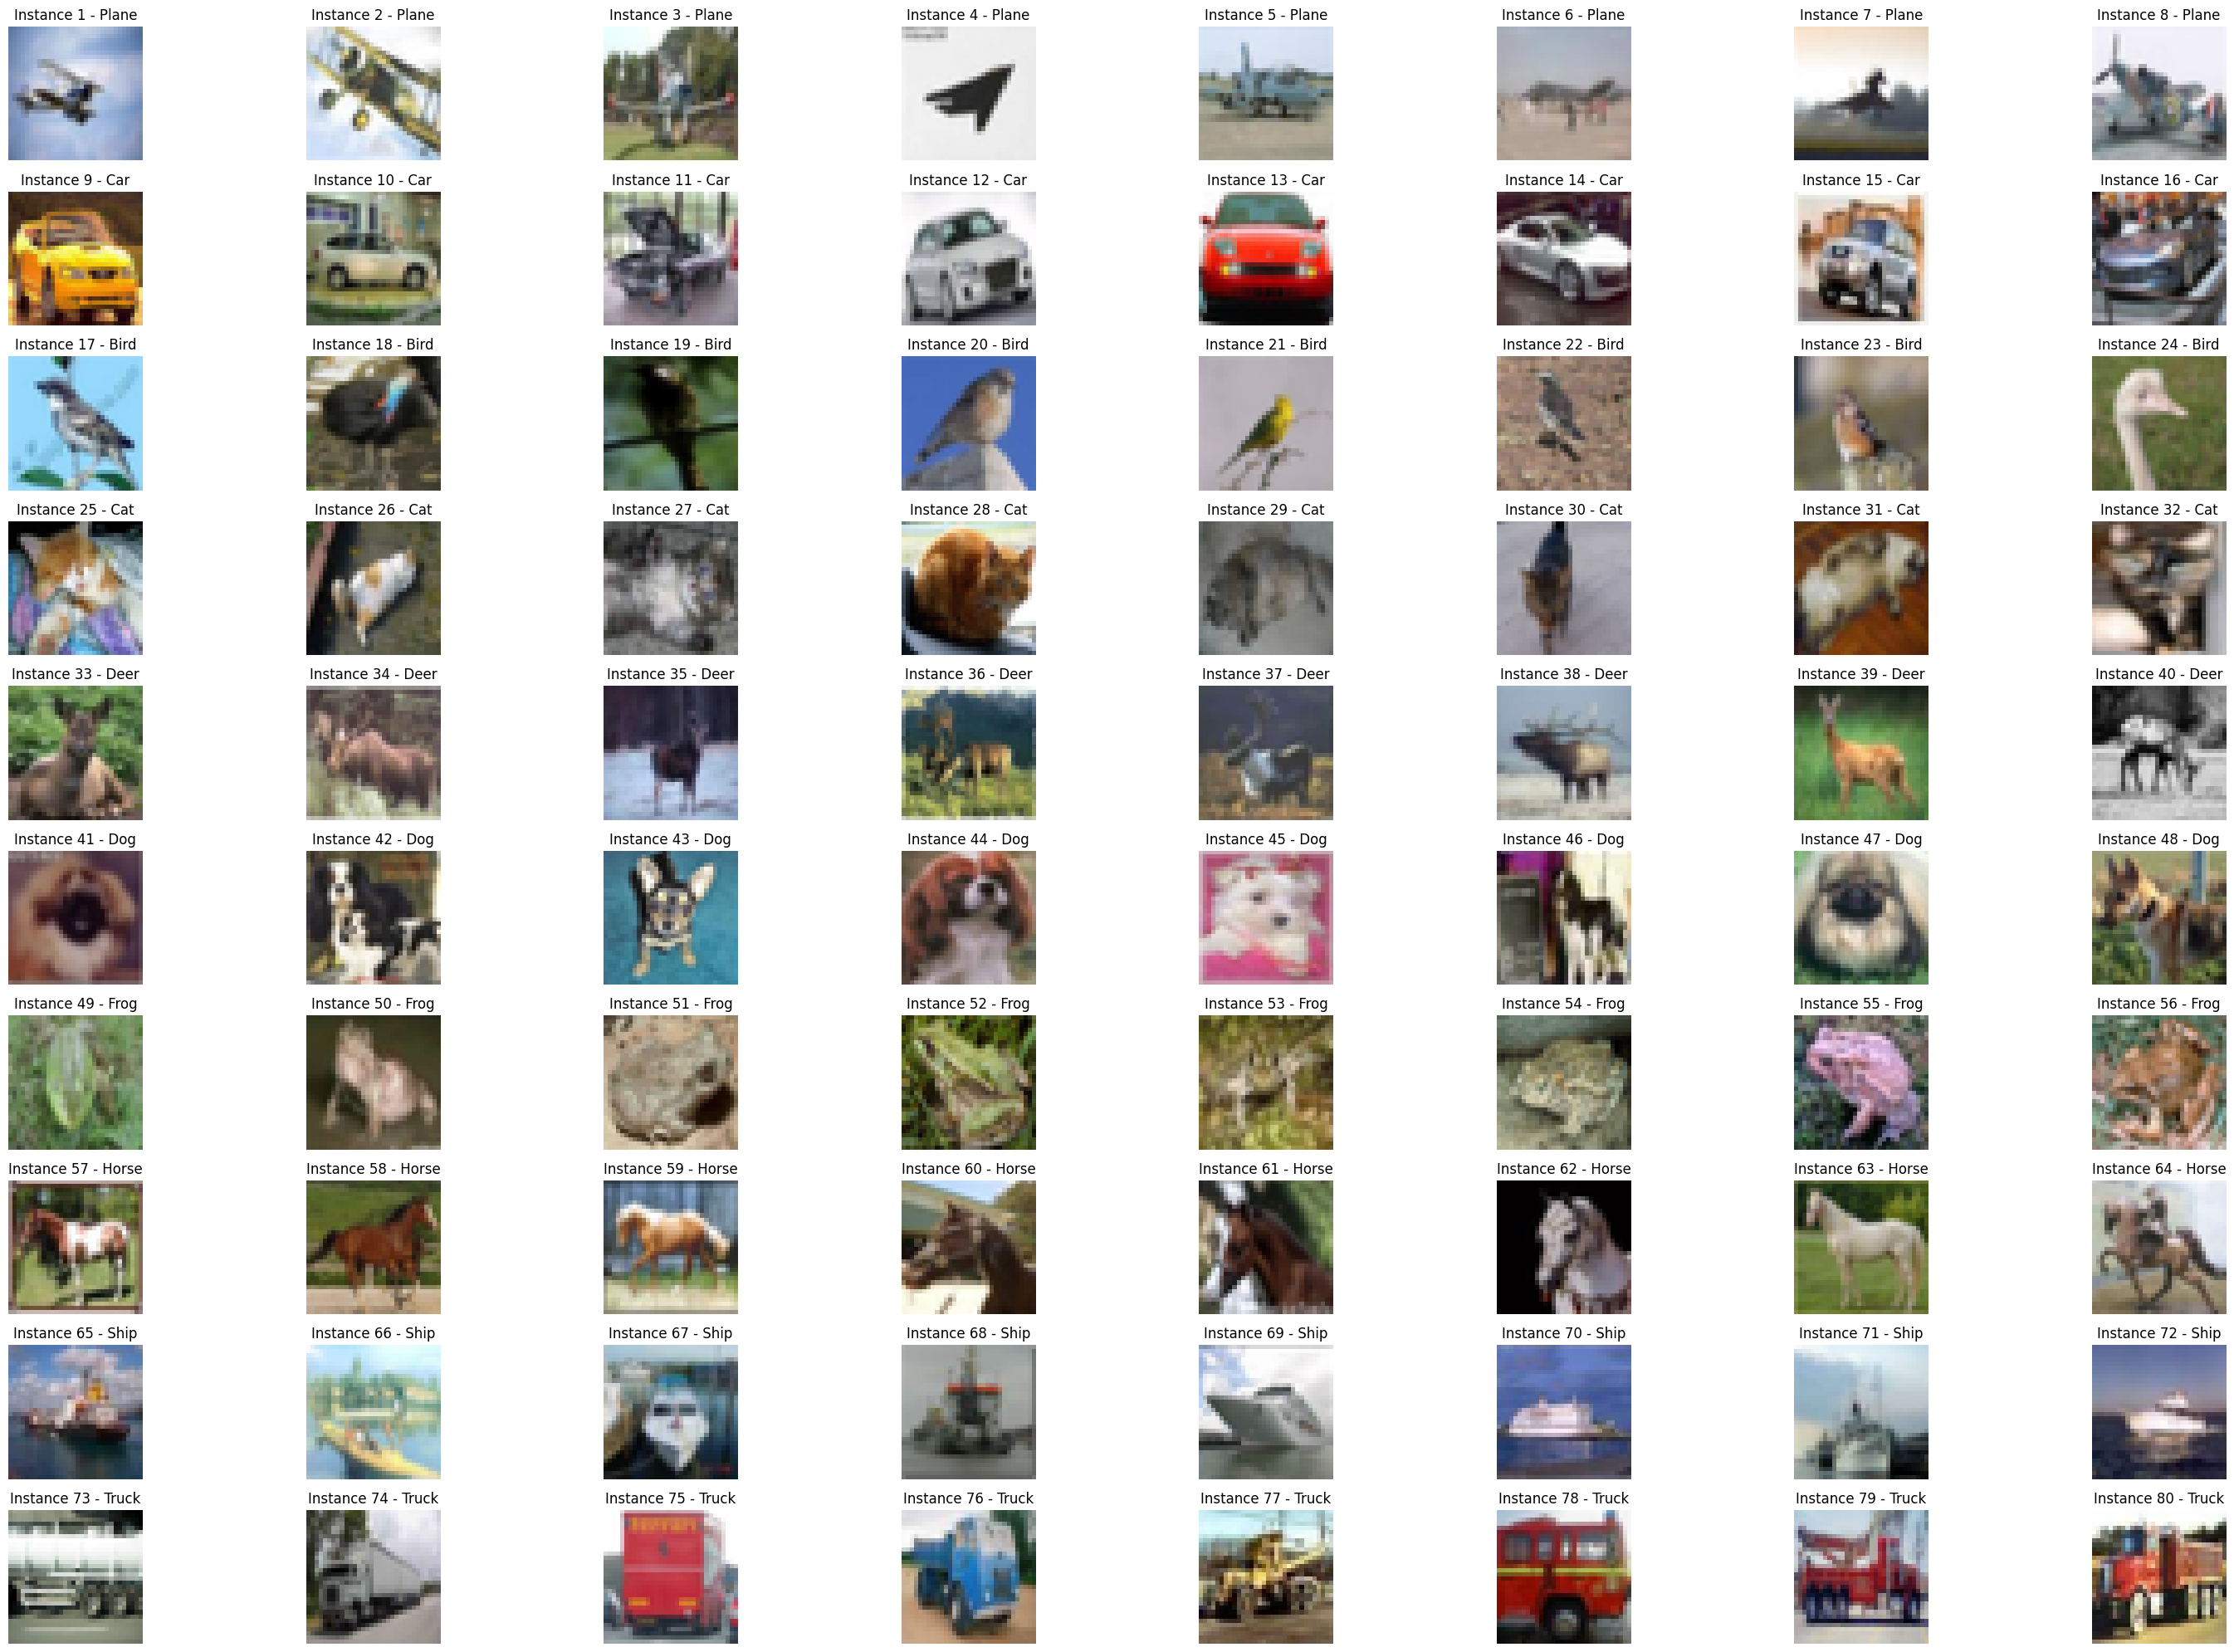

In [2]:
"""----Parameters----"""
random_state = 911

"""----Data Preprocessing----"""
rgb_data = pd.read_csv("rgbdata.csv")
features = rgb_data.columns[:-1]
target = rgb_data.columns[-1]

print(f"length of rgb_data: {len(rgb_data)}")
print(f"length of features: {len(features)}")
print(f"length 1/3 of features: {len(features) // 3}")


def show_rgb_instances(X, y):
    # Define the columns per channel
    cols = len(features) // 3
    if len(features) % 3 != 0:
        raise ValueError(
            "The number of features must be divisible by 3 to split into R, G, and B channels."
        )

    if not np.sqrt(cols).is_integer():
        raise ValueError("The number of columns per channel must be a perfect square.")

    w = int(np.sqrt(cols))  # width & height of the image
    n = len(X)  # number of images

    # Define R, G, B Channels
    R = X.iloc[:, :cols]
    G = X.iloc[:, cols : 2 * cols]
    B = X.iloc[:, 2 * cols :]

    # Reshape the data into 3D arrays
    R = np.reshape(R.values, (n, w, w))
    G = np.reshape(G.values, (n, w, w))
    B = np.reshape(B.values, (n, w, w))

    # Create a tensor
    tensor = np.stack((R, G, B), axis=-1)

    # Generate a plot of 8 columns and k rows
    figure_cols = 8
    figure_rows = (
        n + figure_cols - 1
    ) // figure_cols  # Ensure enough rows for all images
    fig, axes = plt.subplots(figure_rows, figure_cols, figsize=(30, 20))
    axes = axes.flatten()

    for i in range(n):
        axes[i].imshow(tensor[i])
        axes[i].set_title(f"Instance {i + 1} - {y.iloc[i]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Get the fisrt 8 instances of each class
balanced_data = rgb_data.groupby(target).apply(
    lambda x: x.sample(n=8, random_state=random_state)
)
# Re-separate features and target
features_balanced = balanced_data[features]
target_balanced = balanced_data[target]
# Map the target to a string
target_balanced = target_balanced.map(
    {
        0: "Plane",
        1: "Car",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck",
    }
)
# Show the images
show_rgb_instances(features_balanced, target_balanced)

## Exercise 2 (6 Points)
Randomly partition the data to stick with 15000 training instances and 5000 validation instances. The remaining 5000 are test instances, which you never may use during training.  

Use the scikit-learn `MLPClassifier` to train different networks with one, two, and four hidden layers with $n_i \in \{50,\ 200,\ 1000\}$ units per layer each (all layers have the same number of units here in this case). Use the Adam optimizer, and try learning rates $\{10^{-3},\ 10^{-4},\ 10^{-5}\}$. Use  
ReLU as activation function. This should give in total $3 \times 3 \times 3 = 27$ scenarios.

1. For each of these configurations, train the network by performing one epoch after the other. Carefully(!) check the `warm_start` and `max_iter` hyperparameter and/or the `partial_fit` function. Compute the confusion matrix on the 5000 validation instances after each epoch and keep track of these for the best network seen so far. Also compute the accuracy from the confusion matrices and store the accuracies for the architecture in a list (learning curve over the number of epochs). Stop training if you did not find a new best score for at least 50 epochs (not after 50 epochs).

2. Also record for each architecture  

    a) the training time  
    b) the final test performance on the 5000 instances  
    
    Store your results in a dataframe (one row per architecture/learning rate combination).  
    It is recommended to have one column for the learning curves (containing lists).  

    Which was the best accuracy you could achieve among the training instances? For which configuration (architecture + learning rate) did you observe this score? For that configuration, create a GIF animation that shows (i) how the confusion matrix and (ii) validation accuracy (learning curve) evolves over time.

    Create a $3 \times 3$ plot grid, one figure for each combination of number of hidden layers and number of units per layer. Within each figure, create three plots for the respective architecture, one for each value of the learning rate. Also create a horizontal line for the overall best observed score.  

In [3]:
# Split the data into train, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    rgb_data[features], rgb_data[target], test_size=0.4, random_state=random_state
)  # 60% train (15000), 40% temp (10000)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=random_state
)  # 20% val (5000), 20% test (5000)

In [ ]:

# Check the length of each set
print(f"length of train set: {len(X_train)}")
print(f"length of validation set: {len(X_val)}")
print(f"length of test set: {len(X_test)}")

# Define Neural Network Parameters
layers = [1, 2, 4]  # Number of hidden layers
n = [50, 200, 1000]  # Number of neurons in each layer
lr = [1e-3, 1e-4, 1e-5]  # Learning rates

# Define the configurations to run the neural network
configurations = list(iter.product(layers, n, lr))
solver = "adam"  # Optimizer
activation_function = "relu"  # Activation function
classes = pd.unique(y_train)

# Define performance metrics and results
results = pd.DataFrame(
    columns=["layers", "neurons", "learning_rate", "accuracy", "time"]
)


def train_config(
    config, X_train, y_train, X_val, y_val, X_test, y_test, classes, random_state
):
    print(
        f"Training configuration: Layers: {config[0]}, Neurons: {config[1]}, Learning Rate: {config[2]}, time: {time.strftime('%H:%M:%S', time.gmtime(0))}"
    )
    # Destructure the configuration
    layer, neurons, learning_rate = config
    # Define the neural network
    mlp = MLPClassifier(
        hidden_layer_sizes=(neurons,) * layer,
        activation=activation_function,
        learning_rate_init=learning_rate,
        warm_start=True,
        solver=solver,
        max_iter=1,
        random_state=random_state,
    )
    # Define performance parameters
    best_epoch = 0
    best_accuracy = 0
    best_model = None
    confusion_matrix_evolution = []
    learning_curve = []
    no_improvement = 0
    # Train the neural network
    start_time = time.time()

    for epoch in range(100000000):
        # Train the model
        mlp.partial_fit(X_train, y_train, classes=classes)
        # Predict the validation set
        y_pred = mlp.predict(X_val)
        # Calculate the confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        # Calculate the accuracy
        accuracy = accuracy_score(y_val, y_pred)
        # Store the learning curve
        learning_curve.append(accuracy)
        # Store the confusion matrix
        confusion_matrix_evolution.append(cm)

        # Check for improvement
        if accuracy > best_accuracy:
            best_epoch = epoch
            best_accuracy = accuracy
            best_model = copy.deepcopy(mlp)
            no_improvement = 0
        else:
            no_improvement += 1

        # Break condition
        if no_improvement >= 50:
            break

    end_time = time.time()

    # Save the model
    os.makedirs("models", exist_ok=True)
    best_model_filename = f"models/mlp_model_{layer}_{neurons}_{learning_rate}.pkl"
    joblib.dump(best_model, best_model_filename)

    # Test the model
    y_test_pred = mlp.predict(X_test)
    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, y_test_pred)
    # Return the results
    return {
        "epoch": best_epoch,
        "layers": layer,
        "neurons": neurons,
        "learning_rate": learning_rate,
        "accuracy": best_accuracy,
        "learning_curve": learning_curve,
        "confusion_matrix": confusion_matrix_evolution,
        "training_time": end_time - start_time,
        "test_accuracy": test_accuracy,
    }


# Parallel execution
results_list = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_config)(
        config, X_train, y_train, X_val, y_val, X_test, y_test, classes, random_state
    )
    for config in configurations
)

# Convert the results to a DataFrame
results = pd.DataFrame(results_list)
results.to_csv("parallel_results.csv", index=False)

length of train set: 15000
length of validation set: 5000
length of test set: 5000


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done   7 out of  27 | elapsed: 20.8min remaining: 59.4min
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed: 40.5min remaining: 68.9min
[Parallel(n_jobs=-1)]: Done  13 out of  27 | elapsed: 65.9min remaining: 71.0min
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed: 93.6min remaining: 64.3min
[Parallel(n_jobs=-1)]: Done  19 out of  27 | elapsed: 137.2min remaining: 57.8min
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed: 211.8min remaining: 48.1min
[Parallel(n_jobs=-1)]: Done  25 out of  27 | elapsed: 289.9min remaining: 23.2min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 427.6min finished


2. Also record for each architecture  

    a) the training time  
    b) the final test performance on the 5000 instances  
    
    Store your results in a dataframe (one row per architecture/learning rate combination).  
    It is recommended to have one column for the learning curves (containing lists).  

    Which was the best accuracy you could achieve among the training instances? For which configuration (architecture + learning rate) did you observe this score? For that configuration, create a GIF animation that shows (i) how the confusion matrix and (ii) validation accuracy (learning curve) evolves over time.

    Create a $3 \times 3$ plot grid, one figure for each combination of number of hidden layers and number of units per layer. Within each figure, create three plots for the respective architecture, one for each value of the learning rate. Also create a horizontal line for the overall best observed score. 

Columns: ['epoch', 'layers', 'neurons', 'learning_rate', 'accuracy', 'learning_curve', 'confusion_matrix', 'training_time', 'test_accuracy']
Instances: 27
Best result:
epoch                                                             161
layers                                                              4
neurons                                                          1000
learning_rate                                                  0.0001
accuracy                                                       0.4458
learning_curve      [0.2624, 0.2676, 0.2938, 0.2952, 0.3034, 0.329...
confusion_matrix    [array([[144,  38,  44,  22,  40,  52,  23,  3...
training_time                                              3529.12967
test_accuracy                                                    0.43
Name: 25, dtype: object


C:\Users\juansoag\AppData\Local\Temp\ipykernel_25808\3554808212.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_result["learning_curve"] = ast.literal_eval(best_result["learning_curve"])
C:\Users\juansoag\AppData\Local\Temp\ipykernel_25808\3554808212.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_result["confusion_matrix"] = eval(best_result["confusion_matrix"])


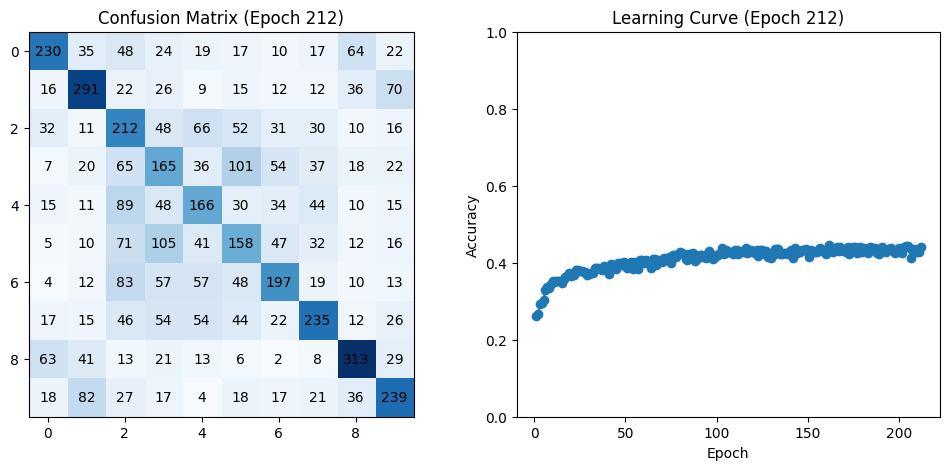

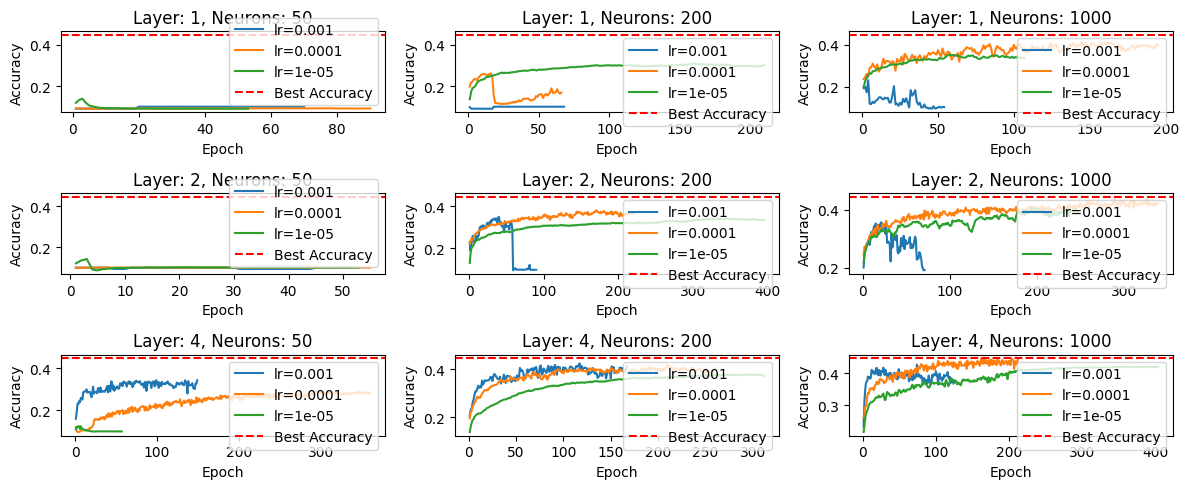

In [15]:
import ast
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Read the results from the CSV file
results = pd.read_csv("parallel_results.csv")

# Columns
print(f"Columns: {list(results.columns)}")
# Number of instances
print(f"Instances: {len(results)}")

max_accuracy_index = results["test_accuracy"].idxmax()
# Get the row with the maximum accuracy
best_result = results.iloc[max_accuracy_index]

# Print the best result
print("Best result:")
print(best_result)

# Parse the string representations of the confusion matrix and learning curve
best_result["learning_curve"] = ast.literal_eval(best_result["learning_curve"])
lc = best_result["learning_curve"]
best_result["confusion_matrix"] = eval(best_result["confusion_matrix"])
cms = best_result["confusion_matrix"]

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


def update(epoch):
    axes[0].clear()
    axes[1].clear()

    # Plot confusion matrix
    cm = np.array(best_result["confusion_matrix"][epoch])
    axes[0].imshow(cm, cmap="Blues")
    axes[0].set_title(f"Confusion Matrix (Epoch {epoch + 1})")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, str(cm[i, j]), ha="center", va="center", color="black")

    # Plot learning curve
    axes[1].plot(
        range(1, epoch + 2), best_result["learning_curve"][: epoch + 1], marker="o"
    )
    axes[1].set_title(f"Learning Curve (Epoch {epoch + 1})")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_ylim(0, 1)


# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(best_result["learning_curve"]), repeat=False
)

# Save the gif
ani.save("evolution.gif", writer="pillow", fps=10)


# Show the learning curves for each layer and number of neurons combination
figure, axes = plt.subplots(
    results["layers"].nunique(), results["neurons"].nunique(), figsize=(12, 5)
)

overall_best_score = results["accuracy"].max()
for i, (layer_name, layer_group) in enumerate(results.groupby("layers")):
    for j, (neurons_name, neurons_group) in enumerate(layer_group.groupby("neurons")):
        for idi, instance in neurons_group.iterrows():
            lc = ast.literal_eval(instance["learning_curve"])
            axes[i, j].plot(
                range(1, len(lc) + 1), lc, label=f"lr={instance['learning_rate']}"
            )
        # Plot a horizontal line for the best accuracy
        axes[i, j].axhline(
            y=overall_best_score, color="r", linestyle="--", label="Best Accuracy"
        )

        axes[i, j].set_title(f"Layer: {layer_name}, Neurons: {neurons_name}")
        axes[i, j].set_xlabel("Epoch")
        axes[i, j].set_ylabel("Accuracy")
        axes[i, j].legend()

plt.tight_layout()
plt.show()

What are your findings with respect to the choice of the number of hidden layers/units
and the learning rate?

Hay una correlación clara entre el número de neuronas y el accuracy máximo, independiente del número de capas. A su vez, a más capas, el modelo también tiene mayor capacidad predictiva, pero este efecto es menos notable, por ejemplo, parece no haber diferencia entre una y dos capas, pero si entre dos y cuatro. En los modelos de una o dos capaz y 50 neuronas, la tasa de aprendizaje más lenta fue la que llegó más alto en su nivel. Esto puede darse porque un alfa más pequeño, con menos neuronas, puede llegar a un punto óptimo y mantener una estabilidad numérica mayor. Para los modelos de 1000 neuronas la tasa de aprendizaje de 0.0001 fue la mejor, esto puede ser porque una tasa de crecimiento mayor puede llegar más rápido al punto óptimo. En términos generales, modelos con menos neuronas y capas son más eficientes y eficaces con tasas de aprendizaje más pequeñas y los modelos más complejos, requieren tasas de aprendizaje mayores.

3. Take the architecture for which you obtained the best configuration and create a prediction vector with labels for the 5000 validation instances. Use the function `show_rgb_instances` to plot the predictions with the respective function for at least 100 instances in the that fold. How many labels are correct?

In [13]:
# Generate a sample of 100 random images from the test set
samples_random_state = 404
sample_ids = X_test.sample(n=100, random_state=samples_random_state).index
# Get the sample images and labels
features_sample = X_test.loc[sample_ids]
target_sample = y_test.loc[sample_ids]

In [14]:
loaded_model = joblib.load("models/mlp_model_4_1000_0.0001.pkl")
y_samples_pred = loaded_model.predict(features_sample)

# Measure accuracy
accuracy = accuracy_score(y_samples_pred,target_sample)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 46.00%


In [11]:
target_mapping =     {
        0: "Plane",
        1: "Car",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck",
    }

y_samples_pred_df = pd.DataFrame({"Predicted": [target_mapping[i] for i in y_samples_pred]})

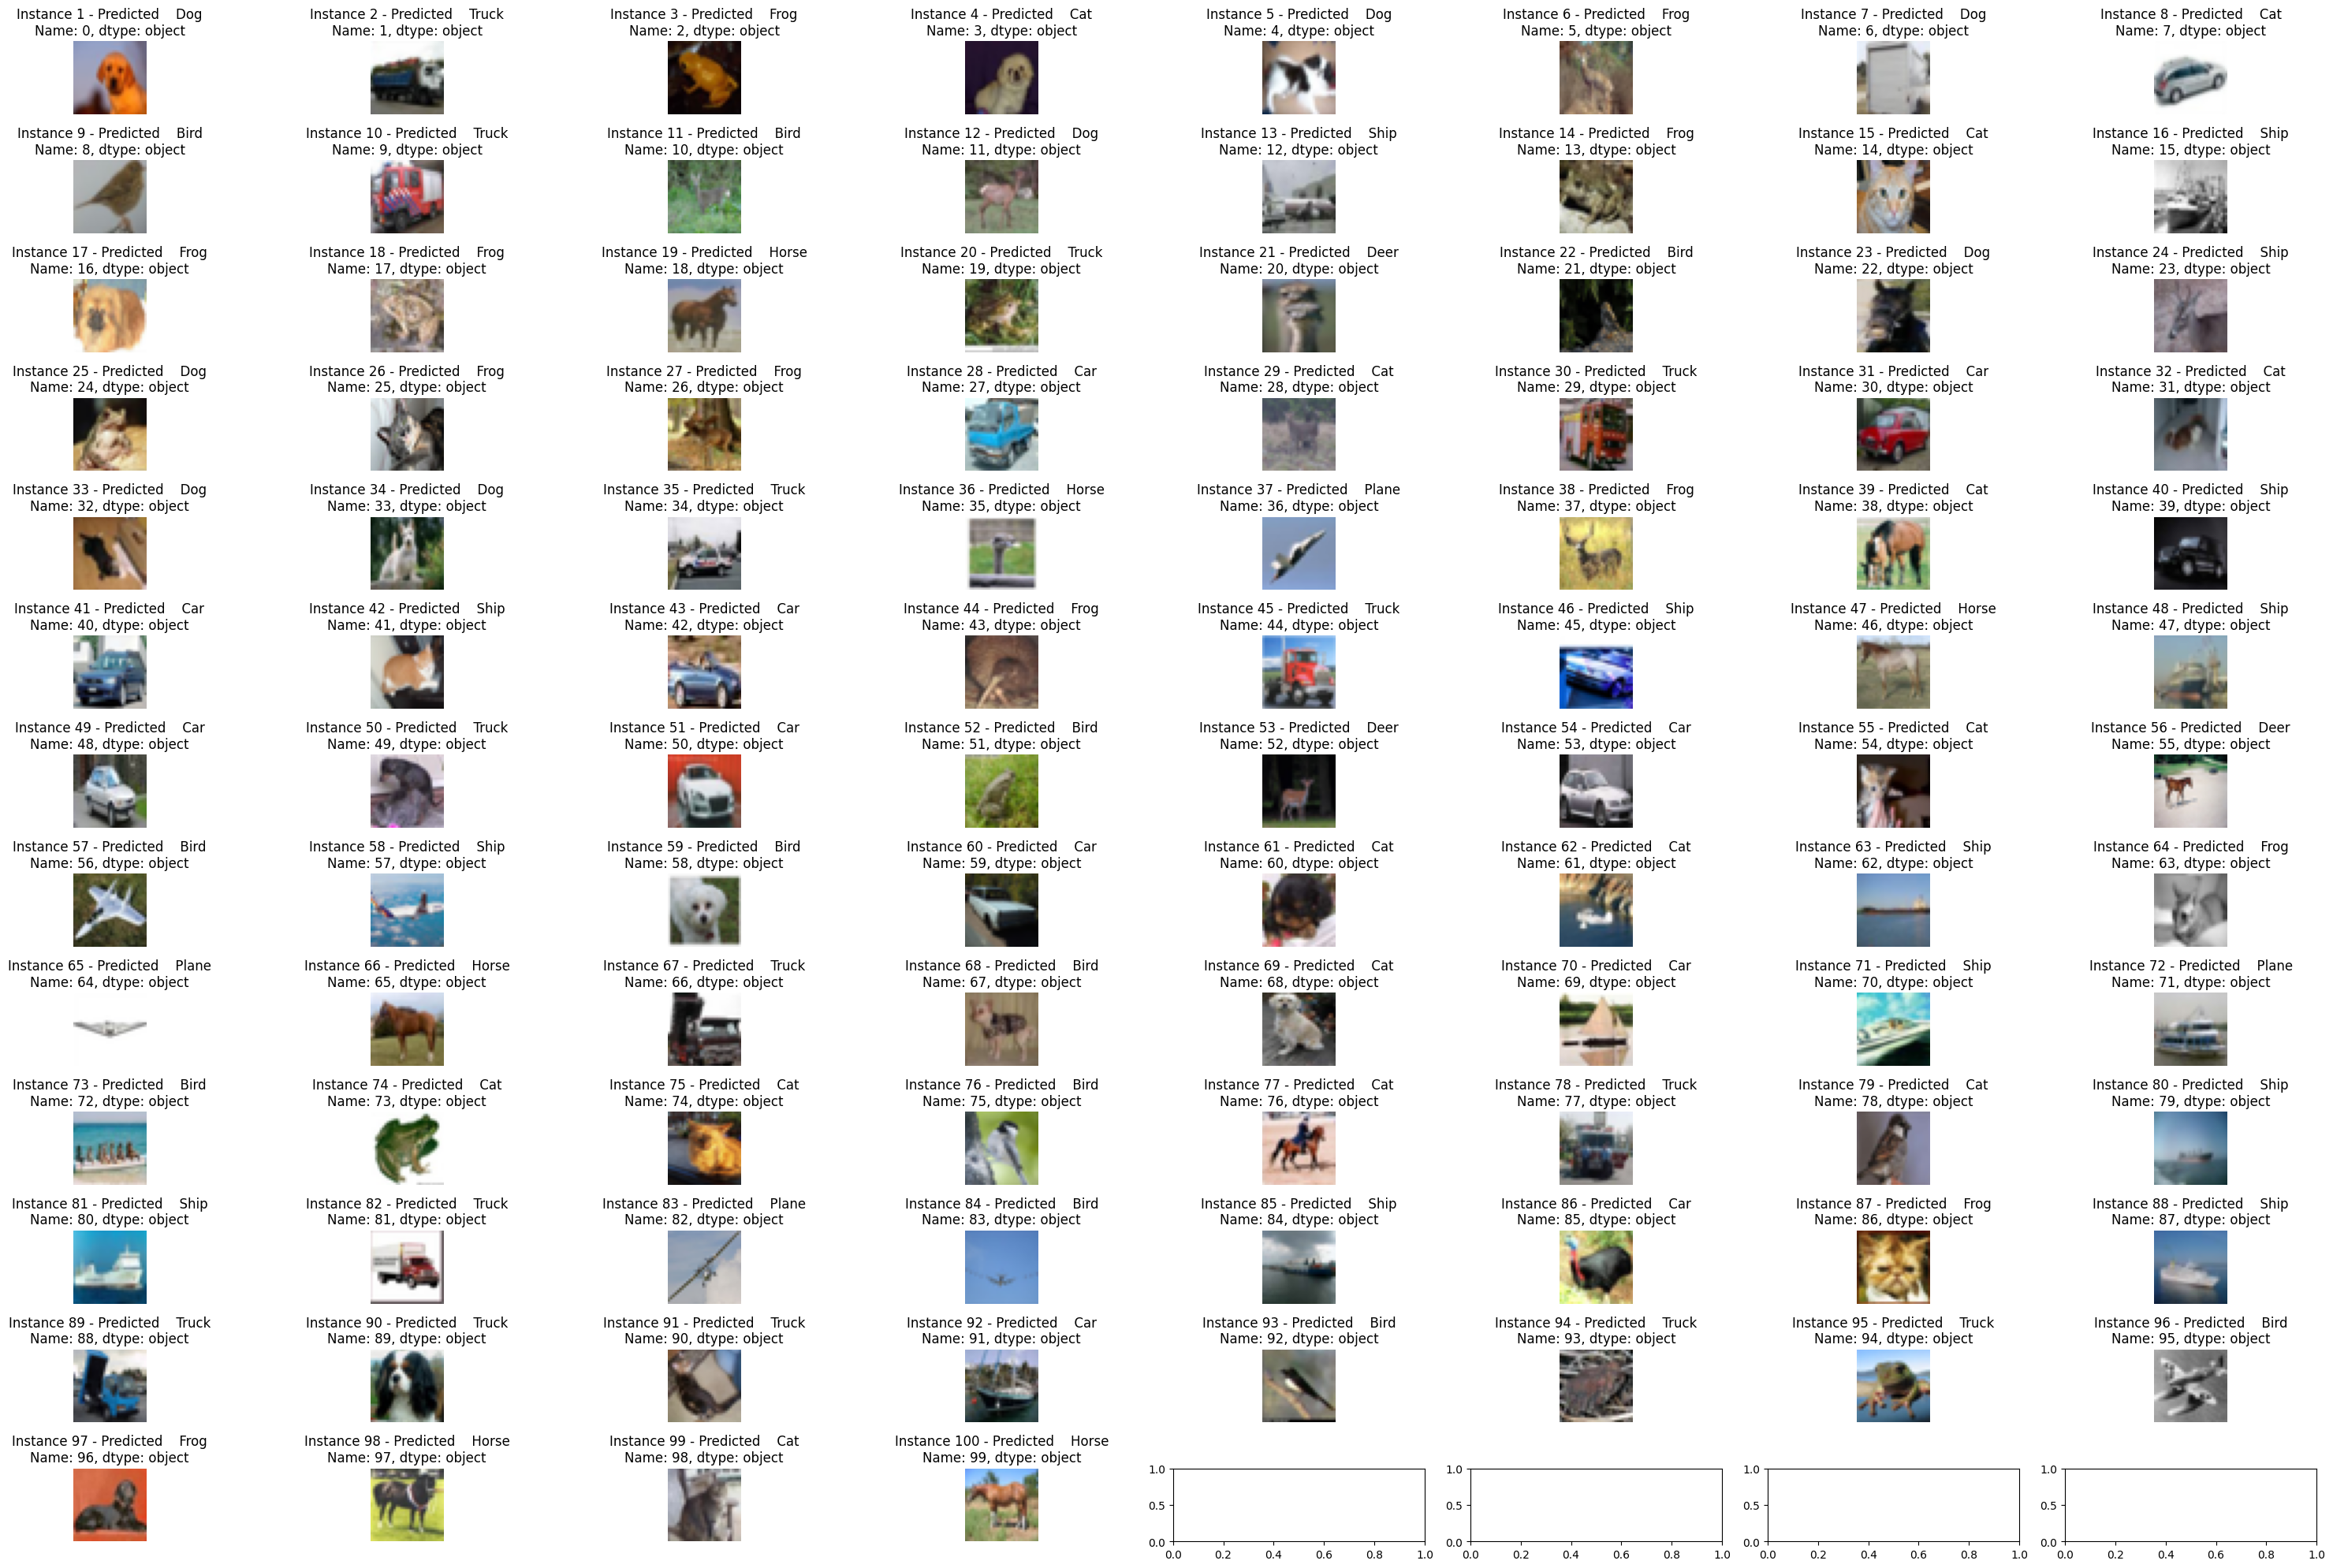

In [12]:
# Show the images
show_rgb_instances(features_sample, y_samples_pred_df)